# Markov Chain Monte Carlo sampling on Kähler moduli space

**What's in this notebook?** This notebook demonstrates how to perform Markov Chain Monte Carlo (MCMC) sampling from the invariant Weil–Petersson (WP) measure on the Kähler moduli space of Calabi–Yau manifolds.

(*Created:* Andreas Schachner, November 3, 2025)

## Imports

In [1]:
# General imports
import sys, os, io, time, pickle, math, corner, emcee, itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
from IPython.display import clear_output

# CYTools imports
from cytools import Polytope
from cytools import fetch_polytopes
from cytools.ntfe import ntfe

# Private imports
sys.path.append("./../code/")
from util import load_zipped_pickle,save_zipped_pickle
from mcmc_functions import emcee_wrapper, emcee_sampler

## Plotting function and settings

In [2]:
def credible_ranges(samples, cred=0.95, pad_frac=0.05):
    """
    Given an (n_samples × ndim) array of samples, return a list of
    (lo, hi) pairs for each dimension, spanning the central `cred`
    credible interval plus a little padding.
    
    cred: fraction, e.g. 0.95 for 95% interval
    pad_frac: fraction of the interval width to add on each side
    """
    qs = [(1 - cred) / 2 * 100, (1 + cred) / 2 * 100]
    ranges = []
    for d in range(samples.shape[1]):
        lo, hi = np.percentile(samples[:, d], qs)
        pad = (hi - lo) * pad_frac
        ranges.append((lo - pad, hi + pad))
    return ranges

# LaTeX-compatible styling (without requiring full LaTeX installation)
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 18,
    "axes.labelsize": 18,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12
})

plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.xmargin'] = 0 
plt.rcParams['hatch.linewidth'] = 10
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['legend.frameon'] = False
plt.rcParams['savefig.bbox'] = "tight"

## Running MCMC for h11=4

We first set some parameters

In [3]:
h11set = 4 # h11
burnin = 50 # How many samples to burn in
scale = 75 # This sets how many statistically independent samples you would want, per walker
max_steps = 1e6 # Set the hard cut on the maximum number of steps any walker will perform

cyvolmaxfactor = 1e10 # Ratio of V_max / V_tip

generator_sampling = False # Set to True for generator sampling. Otherwise it will default to hyperplane (direct) sampling
#generator_sampling = True
lnlik = False # Set True to have a non WP prior
savechain = True # To save a chain
thin = True # To thin the chain so that only statistically independent points are kept
include_cosmology = False # True for plugging in cosmology Keir's likelihood
divvolswitch = False # set True to have at-least one divisor volume < 40 #To have QCD axion

gauge_instanton = True # Set True to replace an O(1) instanton with gauge (QCD-like) instanton
check_quality = True # Set True to check quality of the QCD like instanton (it rejects a point if the quality was poorer than 1e-10)
nwalkers = 100
QCD_div_vol = 40 # Set the value you'd like 
QCD_index_set = 'closest' # This will choose the divisor which has closest volume to "QCD_div_vol"
mpmath_switch = False # whether or not to use mpmath for higher precision
do_Kcup = True # whether to use K_cup or just toric K
#do_Kcup = False
W0set = 1.
print_progress = True # Print progress
verbosity = 0 # For debugging purposes

We pick a CY at $h^{1,1}=4$ and run MCMC

In [4]:
p = fetch_polytopes(h11=h11set,limit=20,as_list=True)[0]
t = p.triangulate()
cy = t.get_cy()

In [5]:
out = emcee_wrapper(cy,
                  burnin = burnin,
                  scale = scale,
                  max_steps = max_steps,
                  cyvolmaxfactor = cyvolmaxfactor,
                  generator_sampling = generator_sampling,
                  lnlik = lnlik,
                  thin = thin,
                  include_cosmology = include_cosmology, 
                  divvolswitch = divvolswitch, 
                  gauge_instanton = gauge_instanton,
                  check_quality = check_quality,
                  QCD_div_vol = QCD_div_vol,
                  QCD_index_set = QCD_index_set,
                  W0set = W0set,
                  nwalkers = nwalkers,
                  do_Kcup = do_Kcup,
                  mpmath_switch = mpmath_switch,
                  print_progress = print_progress,
                  verbosity = verbosity)

if include_cosmology:
    converged,cyvolmax,dt,tsets,logprobs,derived_params,other = out
else:
    converged,cyvolmax,dt,tsets,logprobs = out

▶ Initial condition number: 1.4e+03
Burn-in…


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 242.28it/s]


Main chain…


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:04<00:00, 232.06it/s]


… 1056 steps, τ_max=56.97892454795154; using check_every=56
… 1112 steps, τ_max=57.869205696235476; using check_every=57
… 1169 steps, τ_max=58.74204616799986; using check_every=58
… 1227 steps, τ_max=60.88236079369419; using check_every=60
… 1287 steps, τ_max=63.14194793906074; using check_every=63
… 1350 steps, τ_max=64.91749787827112; using check_every=64
… 1414 steps, τ_max=66.35030297652217; using check_every=66
… 1480 steps, τ_max=67.11928401077208; using check_every=67
… 1547 steps, τ_max=67.91783097090507; using check_every=67
… 1614 steps, τ_max=68.68630590553785; using check_every=68
… 1682 steps, τ_max=70.79661864983504; using check_every=70
… 1752 steps, τ_max=71.37923409544122; using check_every=71
… 1823 steps, τ_max=73.15616149543976; using check_every=73
… 1896 steps, τ_max=74.249589174013; using check_every=74
… 1970 steps, τ_max=74.8345955631711; using check_every=74
… 2044 steps, τ_max=76.57059999663271; using check_every=76
… 2120 steps, τ_max=79.39666005066942; usi

Let us make a plot 

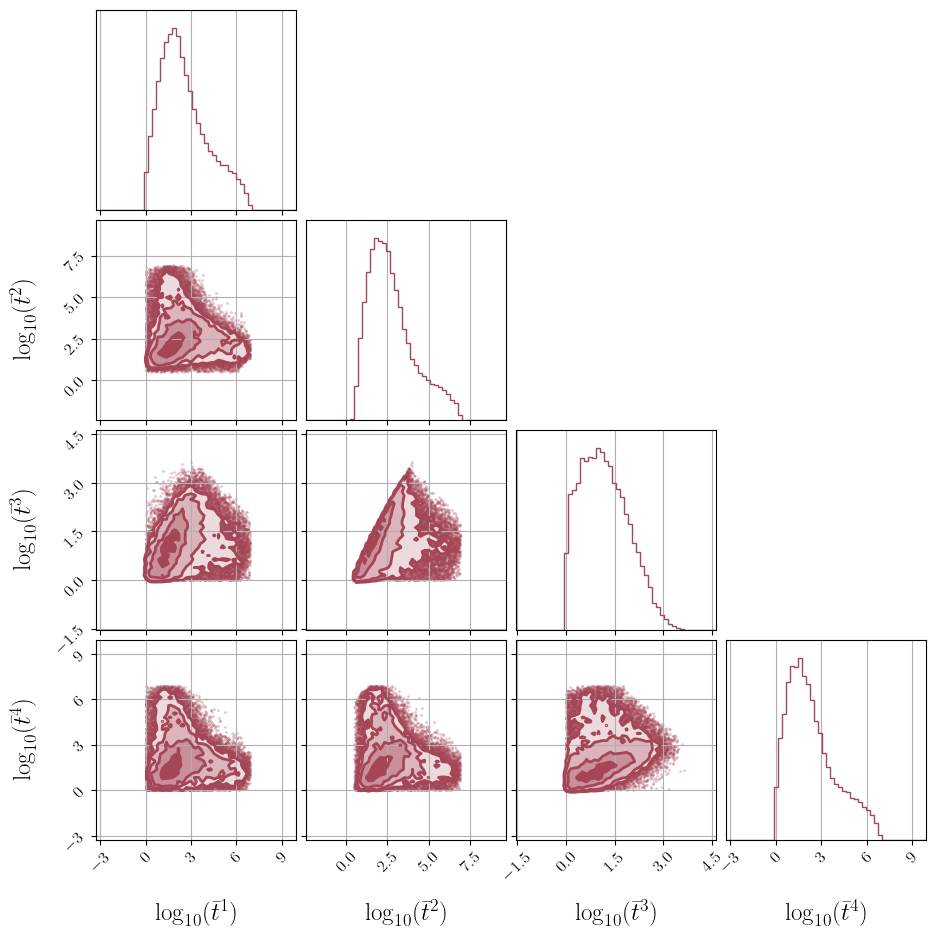

In [6]:
# Get log t
log_t = np.log10(np.sign(tsets)*tsets)

# Get labels
labels = [f"$\\log_{{10}}(\\bar{{t}}^{{{i+1}}})$" for i in range(log_t.shape[1])]

# Set ranges
ranges = credible_ranges(log_t, cred=0.99, pad_frac=0.5)

# Make corner plot
fig = corner.corner(
    log_t,
    labels=labels,
    data_kwargs = {"alpha":0.3},
    color='#A54657',
    bins=50,
    range=ranges,
    show_titles=False,
    title_fmt=".2f",
    plot_datapoints=True,
    fill_contours=True,
    quantiles=[0.16, 0.5, 0.95],  # which quantiles to mark
)

# 2) reshape the flat list of axes into an (ndim × ndim) grid
ndim = log_t.shape[1]
axes = np.array(fig.axes).reshape((ndim, ndim))

# 3) remove the vertical line on each 1D marginal
for i in range(ndim):
    # ax.lines holds the axvline()/axhline() artists
    for line in axes[i, i].get_lines():
        line.set_visible(False)



plt.show()

## Random sampling of CYs

We can sample geometries for a given polytope using the following wraper functin

In [8]:
h11set = 8
p = fetch_polytopes(h11=h11set,limit=20,as_list=True)[0]

ERROR! Session/line number was not unique in database. History logging moved to new session 2056


In [ ]:
path_dir = "./data/test_run/"
print_progress = False
verbosity = 1

emcee_sampler(p, # This is the polytope
              N = 5, # The number of geometries to sample
              path_dir = path_dir, # 
              burnin = burnin,
              scale = scale,
              max_steps = max_steps,
              cyvolmaxfactor = cyvolmaxfactor,
              generator_sampling = generator_sampling,
              lnlik = lnlik,
              thin = thin,
              include_cosmology = include_cosmology, 
              divvolswitch = divvolswitch, 
              gauge_instanton = gauge_instanton,
              check_quality = check_quality,
              QCD_div_vol = QCD_div_vol,
              QCD_index_set = QCD_index_set,
              W0set = W0set,
              nwalkers = nwalkers,
              do_Kcup = do_Kcup,
              mpmath_switch = mpmath_switch,
              print_progress = print_progress,
              verbosity = verbosity)

Did not find sufficiently many FRSTs. Found 4, need 5.
#FRST: (1/4)     #converged chains: 0    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:03<00:00, 267.67it/s]


In [1]:
379244-10500

368744